1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau} = \frac{\ln 2}{\tau}e^{-\frac{t}{\tau}\ln 2}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random as npr
%matplotlib inline

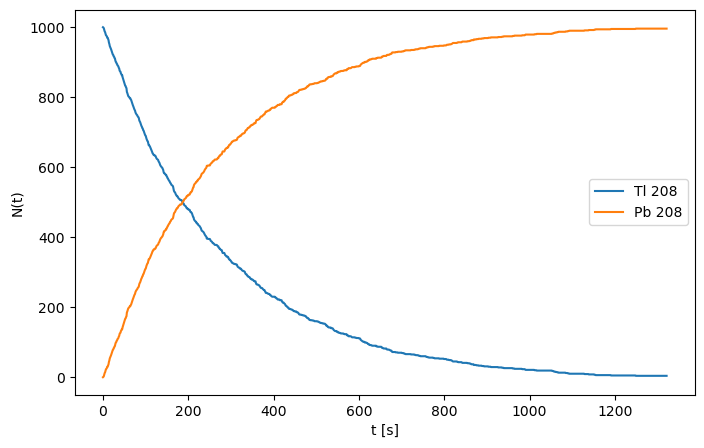

In [2]:
t_1_2 = 3.052*60/np.log(2)      # half_life = log(2) * tau (sec)
dt = 1
sigma = 5
N_Tl = np.zeros(int(sigma*t_1_2))
N_Pb = np.zeros(int(sigma*t_1_2))
N_Tl[0] = 1000
N_Pb[0] = 0

def p(t, tau=3.052*60):
    return 1 - 2**(-t/tau)

time = 0
prob = npr.uniform(0, 1, int(N_Tl[0]))
for time in range(1, int(sigma*t_1_2)):
    N_Pb[time] = np.sum(prob < p(time)) # counts the number of decayed atoms 
    N_Tl[time] = N_Tl[0] - N_Pb[time]

plt.figure(figsize=(8, 5))
x = np.linspace(0, sigma*t_1_2, N_Tl.size, )
plt.xlabel('t [s]')
plt.ylabel('N(t)')
plt.plot(x, N_Tl, label='Tl 208')
plt.plot(x, N_Pb, label='Pb 208')
plt.legend(loc='best')
plt.show()

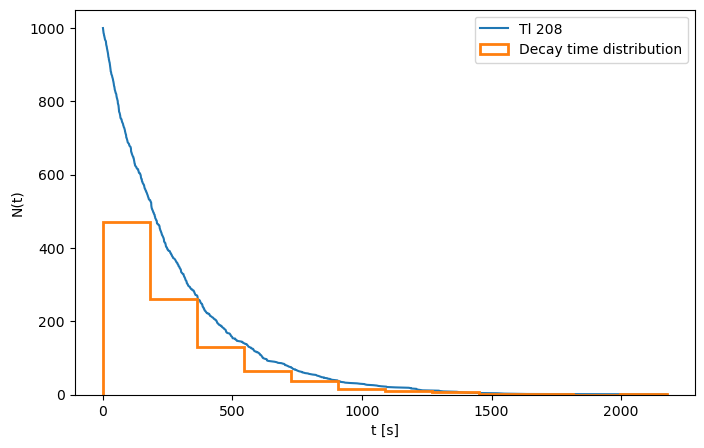

In [3]:
# We have to draw 1000 points from an exponential distribution

def expon_icdf(z, mu=np.log(2)/(3.052*60)):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log(1-z)/mu 

u = np.random.random(1000)
times_of_decay = sorted(expon_icdf(u))
N_Tl = np.zeros(len(times_of_decay))
N_Tl[0] = 1000

for t in range(1, len(times_of_decay)):
    N_Tl[t] = N_Tl[t-1] - 1

plt.figure(figsize=(8, 5))
x = np.linspace(0, sigma*t_1_2, N_Tl.size)
plt.xlabel('t [s]')
plt.ylabel('N(t)')
plt.plot(times_of_decay, N_Tl, label='Tl 208')
plt.hist(times_of_decay, histtype='step', bins=12, linewidth=2, label='Decay time distribution')
plt.legend(loc='best')
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back", i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [4]:
Bohr_rad = 5e-11 # m 
sigma = Bohr_rad/100
alpha = int(1e6) # one million alpha particles
scattering_condition = np.pi/2

def Rutherford_tan(b, E=7.7e6, eps0=8.85e-12, e=1.6e-19, Z=79):
    return Z*e/(2*np.pi*eps0*E*b)

# generate b from double-gaussian distribution
z = np.random.random(alpha)
theta = 2*np.pi*np.random.random(alpha)
r = np.sqrt(-2*sigma**2*np.log((1-z)))
data = pd.DataFrame({'x':r*np.cos(theta), 'y':r*np.sin(theta)})
data['b'] = np.sqrt(data['x']**2+data['y']**2)
tan_theta = Rutherford_tan(data['b']).values
theta = 2*np.arctan(tan_theta)

bounce_back = theta[theta > scattering_condition]
print(f"The fraction of particles bouncing back is {(bounce_back.size/alpha*100)} %")

The fraction of particles bouncing back is 0.1729 %


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [5]:
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

In [6]:
def f(x):
    return np.sin(1/(x*(2-x)))**2

a, b = 0, 2

# Hint/miss method

N = 1000000
counts = 0
for _ in range(N):
    x = npr.uniform(0, 2)
    y = npr.uniform(0, 1)
    if y < f(x):
        counts += 1

res = quad(f, a, b)[0]
integral = 2*counts/N
# print(res)
print(f"The estimated area is {integral}, with an error of {np.abs(integral-res)/res*100} %")

The estimated area is 1.45167, with an error of 0.001222782313646989 %


In [7]:
# Mean value method

eps = 1e-5
integral2 = (b-a)* sum([f(x) for x in npr.random(N)])/N
print(f"The estimated area is {integral2}, with an error of {np.abs(integral2-res)/res*100} %")
print(f"Compared with the previous result the error is, with an error of {np.abs(integral-integral2)/integral*100} %")

The estimated area is 1.4519628002660394, with an error of 0.018946862697238904 %
Compared with the previous result the error is, with an error of 0.020169891644753607 %


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [8]:
N = int(1e6)
count = 0
for i in range(N):
    x = npr.uniform(0, 1)
    y = npr.uniform(0, 1)
    r = np.sqrt(x**2 + y**2)
    if r <= 1: count += 1
area = 4*count/N    # the factor 4 is due to the fact that we are considering just a quarter of the entire circle
print(f"The area estimated is {area}, really close to the expected one of {np.pi}: {np.abs(area-np.pi)/np.pi}% of error")

The area estimated is 3.144156, really close to the expected one of 3.141592653589793: 0.0008159385040826367% of error


In [9]:
# Generalizing to a 10D sphere

N = int(1e6)
dim = 10
count = 0
for i in range(N):
    vec = npr.uniform(0, 1, size=10)    # 10 elements as a vector
    r = np.sqrt(sum(vec**2))
    if r <= 1: count += 1
area = 4*count/N * 2**(dim-2)   # the factor 4 is due to the fact that we are considering just a quarter of the entire circle in 2D
real_volume = np.pi**5/120
print(f"The area estimated is {area}, really close to the expected one of {real_volume}: {np.abs(area-real_volume)/real_volume}% of error")

The area estimated is 2.569216, really close to the expected one of 2.550164039877345: 0.00747087631412574% of error


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [10]:
def f(x):
    return (x**(-0.5))/(np.exp(x)+1)

def w(x):
    return 1/np.sqrt(x)

a, b = 0, 1

x = npr.random(N)
integral_w = (b-a)*np.sum(w(x))/N

x = npr.random(N)**2    # we need to invert the sampling, since we took the square root before
I = sum(f(x)/w(x))*integral_w*(b-a)/N
print(f"The integral value is I = {I}")

The integral value is I = 0.838665210772267
